In [1]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import colormath

In [14]:
model_name = 'D2GANNZ/'
root = '/work3/s212645/Spectral_Reconstruction/checkpoint/'
metrics = 'metrics.pth'
modelname = 'net_0099epoch.pth'
path = root + model_name + metrics
result = torch.load(path, map_location=torch.device('cpu'))
path = root + model_name + modelname
model_dict = torch.load(path, map_location=torch.device('cpu'))
print(model_dict['epoch'])

99


In [15]:
MRAE = result['MRAE']
RMSE = result['RMSE']
PSNR = result['PSNR']
SAM = result['SAM']
length = len(MRAE)
for i in range(length):
    MRAE[i] = MRAE[i].item()
for i in range(length):
    RMSE[i] = RMSE[i].item()
for i in range(length):
    PSNR[i] = PSNR[i].item()
for i in range(length):
    SAM[i] = SAM[i].item()
print(length)

138


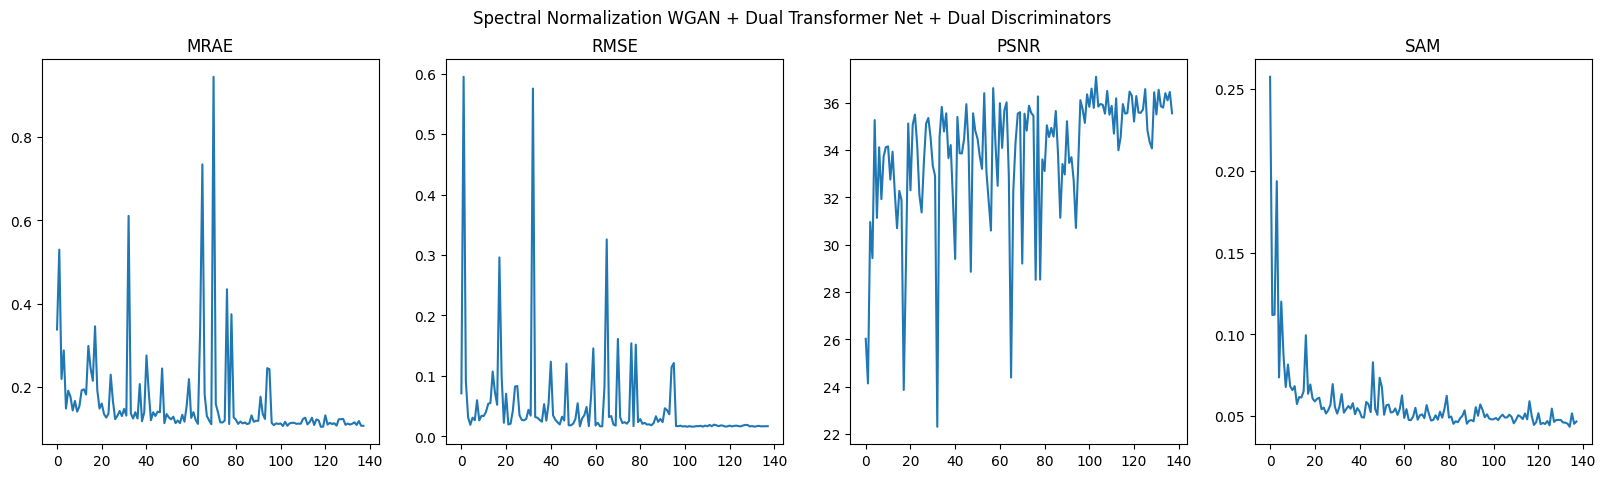

In [5]:
plt.figure(figsize=[20,5])
plt.suptitle("Spectral Normalization WGAN + Dual Transformer Net + Dual Discriminators") 
plt.subplot(1, 4, 1)
plt.plot(range(length), MRAE[:length])
plt.title("MRAE")

plt.subplot(1, 4, 2)
plt.plot(range(length), RMSE[:length])
plt.title("RMSE")

plt.subplot(1, 4, 3)
plt.plot(range(length), PSNR[:length])
plt.title("PSNR")

plt.subplot(1, 4, 4)
plt.plot(range(length), SAM[:length])
plt.title("SAM")
filename = 'result/'+model_name.split('/')[0]+'.png'
plt.savefig(filename)

In [6]:
import scipy.io
import numpy as np
import cv2

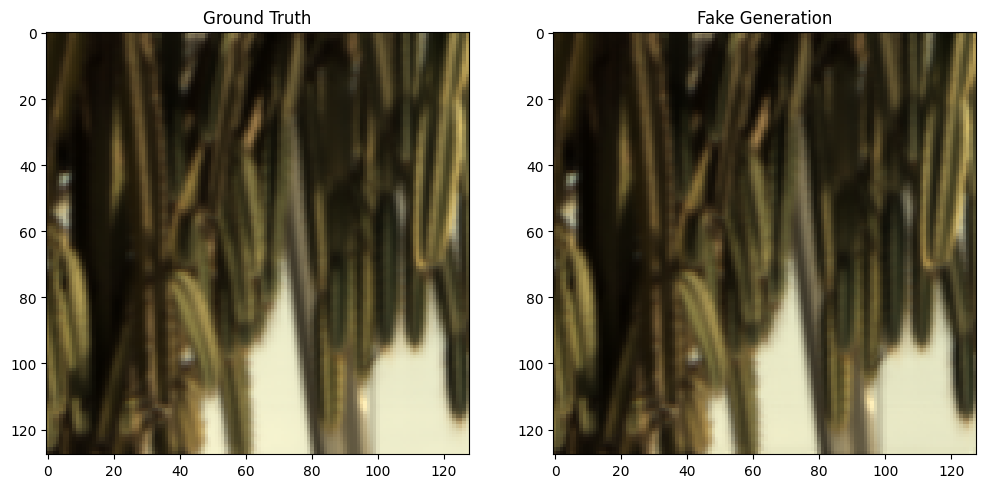

In [7]:
# realroot = '/work3/s212645/Spectral_Reconstruction/RealHyperSpectrum/SNCWGAN/'
# fakeroot = '/work3/s212645/Spectral_Reconstruction/FakeHyperSpectrum/SNCWGAN/'
# realroot = '/work3/s212645/Spectral_Reconstruction/RealHyperSpectrum/D2GAN/'
# fakeroot = '/work3/s212645/Spectral_Reconstruction/FakeHyperSpectrum/D2GAN/'
# realroot = '/work3/s212645/Spectral_Reconstruction/RealHyperSpectrum/SNCWGANNoNoise/'
# fakeroot = '/work3/s212645/Spectral_Reconstruction/FakeHyperSpectrum/SNCWGANNoNoise/'
realroot = '/work3/s212645/Spectral_Reconstruction/RealHyperSpectrum/SNCWGANNoNoise/'
fakeroot = '/work3/s212645/Spectral_Reconstruction/FakeHyperSpectrum/SNCWGANNoNoise/'

k = 8
num = str(k).zfill(3)
name = num + '.mat'

fakergb = scipy.io.loadmat(fakeroot + name)['rgb']
fakergb = (fakergb - fakergb.min()) / (fakergb.max()-fakergb.min())

realrgb = scipy.io.loadmat(realroot + name)['rgb']
realrgb = (realrgb - realrgb.min()) / (realrgb.max()-realrgb.min())

plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.imshow(realrgb)
plt.title('Ground Truth')
plt.subplot(1, 2, 2)
plt.imshow(fakergb)
plt.title('Fake Generation')
plt.savefig('Reconstructed RGB image')

<Axes: >

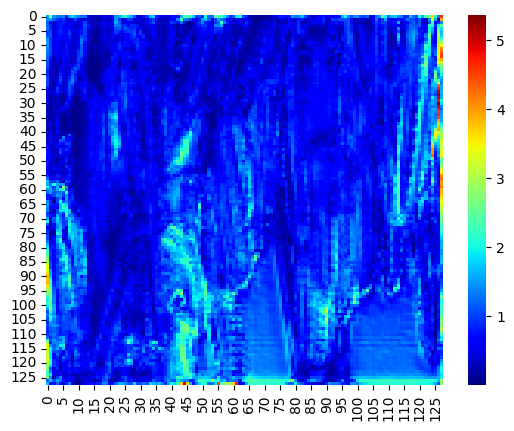

In [8]:
import seaborn as sns
import colour
image1_lab = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(realrgb))
image2_lab = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(fakergb))
colour.delta_E(image1_lab, image2_lab).mean()
deltae = colour.delta_E(image1_lab, image2_lab)
sns.heatmap(deltae, cmap='jet')

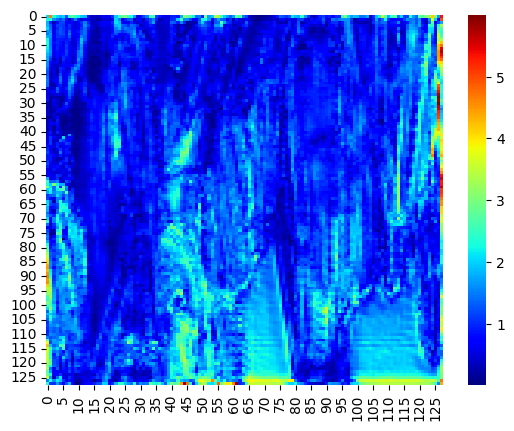

In [9]:
colour.delta_E(image1_lab, image2_lab, method="CIE 1976").mean()
deltae = colour.delta_E(image1_lab, image2_lab, method="CIE 1976")
sns.heatmap(deltae, cmap='jet')
plt.savefig('Delta E Heatmap')

<Axes: >

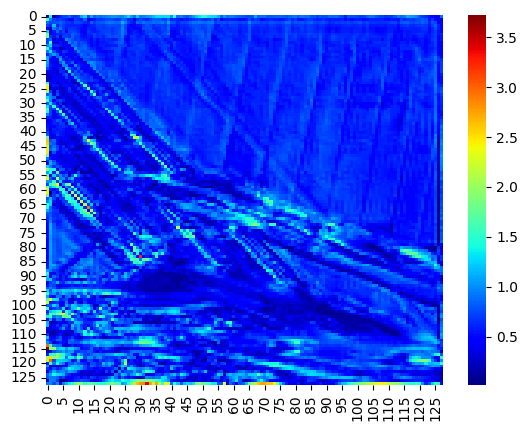

In [9]:
colour.delta_E(image1_lab, image2_lab, method="CIE 2000")
deltae = colour.delta_E(image1_lab, image2_lab, method="CIE 2000")
sns.heatmap(deltae, cmap='jet')

1. Spatial Disc and Spectral Disc 
2. Heat maps of {MRAE, SAM , deltaE_1976 or 2000}
3. Diffusion Model

In [11]:
def MRAE(x,y):
    return (x-y) ** 2
fake = scipy.io.loadmat(fakeroot + name)['cube']
# fake = (fake - fake.min()) / (fake.max()-fake.min())
real = scipy.io.loadmat(realroot + name)['cube']
# real = (real - real.min()) / (real.max()-real.min())

In [19]:
COLOR = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
COLOR = sns.color_palette("light:b", as_cmap=True)
bands = np.linspace(400, 700, 31)
for i in range(31):
    band = bands[i]
    data = MRAE(real, fake)[:,:,i]
    # plt.subplot(6, 6, i+1)
    sns.heatmap(data, cmap='jet')
    plt.title('MRAE Hearmap Band: {}'.format(band))
    filename = 'result/Figures/MRAEHeatmap_'+str(band)+'.png'
    plt.savefig(filename)
    plt.close()

In [20]:
def SAMHeatMap(preds, target):
    dot_product = np.sum(preds * target, axis=2)
    preds_norm = np.linalg.norm(preds, axis=2)
    target_norm = np.linalg.norm(target, axis=2)
    sam_score = np.arccos(dot_product / (preds_norm * target_norm))
    return sam_score

sam = SAMHeatMap(fake, real)

In [21]:
sns.heatmap(sam, cmap='jet')
filename = 'result/Figures/SAMHeatmap.png'
plt.savefig(filename)
plt.close()


YCbCr Color space Y channel for SSIM and PSNR

Grey image for SSIM and PSNR

Generate results: heatmap, convergence resultes

In [8]:
from utils import Loss_SSIM
ssim = Loss_SSIM()
fakergb = torch.from_numpy(fakergb.transpose(2,0,1)).unsqueeze(dim=0)
realrgb = torch.from_numpy(realrgb.transpose(2,0,1)).unsqueeze(dim=0)


torch.Size([1, 3, 128, 128])
